## Description:

    Evaluate community differences between treated seeds and untreated controlls



# Init

In [1]:
%load_ext rpy2.ipython

In [29]:
%%R

library(ggplot2)
library(foreach)
library(doParallel)
library(gridExtra)
library(dplyr)
library(tidyr)
library(vegan)
library(DESeq2)
library(phyloseq)
library(lmerTest)
library(lsmeans)

/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: Matrix

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘Matrix’


  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following object is masked from ‘package:S4Vectors’:

    expand


  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: lme4

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘lmerTest’


  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following object is masked from ‘package:lme4’:

    lmer

In [70]:
%%R
# set theme for ggplot

theme_pub = function (base_size = 11, base_family = "Helvetica") 
{
    theme_grey(base_size = base_size, base_family = base_family) %+replace% 
        theme(
            axis.line.x = element_line(size = .5),
            axis.line.y = element_line(size = .5),
            panel.background = element_rect(fill = "white", colour = NA), 
            panel.border = element_rect(fill = NA, color = "black", size = .5), 
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(), 
            strip.background = element_rect(fill = "grey85", 
                colour = "grey20"), 
            legend.key = element_rect(fill = "white", 
                colour = NA), complete = TRUE)
    }

library(RColorBrewer)
TreatmentColors = brewer.pal(3, 'Dark2')

# Loading phyloseq object

In [4]:
%%R
setwd('/home/bryan/ERA/data/MiSeq/20170417_run1/phyloseq/')

In [78]:
%%R 
# loading

physeq = readRDS('ERA_snorm.rds')

physeq = transform_sample_counts(physeq, function(x) sqrt(x))
#remove T0, not necessary
physeq = subset_samples(physeq, !is.na(Genotype), TRUE)
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4592 taxa and 243 samples ]
sample_data() Sample Data:       [ 243 samples by 46 sample variables ]
tax_table()   Taxonomy Table:    [ 4592 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4592 tips and 4591 internal nodes ]


In [79]:
%%R
sample_data(physeq)$Rep = as.factor(sample_data(physeq)$Rep)
sample_data(physeq)$Row = as.factor(sample_data(physeq)$Row)
sample_data(physeq)$Fert = as.factor(sample_data(physeq)$Fert)

In [80]:
%%R
sample_data(physeq)$Plant %>%
    levels

 [1] "322"     "322U"    "330"     "339"     "3394"    "3475"    "3475U"  
 [8] "34M95"   "34N42"   "34N42U"  "3517"    "354"     "3541"    "354U"   
[15] "3618"    "Bare"    "P1151HR"


* 322, 3475, 34N42, and 354 have plots with both treated and untreated seeds that were sampled at T2

In [81]:
%%R
phy.st = subset_samples(physeq, Genotype %in% c("322", "3475", "34N42", "354") & TimePoint == "T2")
phy.st

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4592 taxa and 32 samples ]
sample_data() Sample Data:       [ 32 samples by 46 sample variables ]
tax_table()   Taxonomy Table:    [ 4592 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4592 tips and 4591 internal nodes ]


In [82]:
%%R
sample_data(phy.st)$R_Year %>%
    unique

[1] 1936 2003 1953 1984


* does not include treated plants with multivariate outliers

# Calculate distances matrices 

In [83]:
%%R
registerDoParallel(cores=28)
bray.dist = distance(phy.st, 
                      method = "bray", 
                      weighted = FALSE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [84]:
%%R
phy.st %>% 
    sample_data() %>%
    colnames()

 [1] "X.sampleID"      "TubeID"          "ExtractionPlate" "PooledDNAPlate" 
 [5] "Sample.Well.ID"  "PrimerPlate"     "Primer.Number"   "Primer.Well.ID" 
 [9] "X"               "primerFwdLoc"    "primerRevLoc"    "fwd_barcode"    
[13] "rev_barcode"     "PlotID"          "TimePoint"       "Rep"            
[17] "Row"             "Pos"             "Fert"            "PlotIndex"      
[21] "Plant"           "Genotype"        "SeedTreatment"   "R_Year"         
[25] "ERA"             "BG_activity.g"   "BX_activity.g"   "CB_activity.g"  
[29] "LAP_activity.g"  "NAG_activity.g"  "Stage"           "kgdw_ha"        
[33] "FracN.leco"      "FracC.leco"      "kgN_ha"          "RGR"            
[37] "AGR"             "Nprod"           "NupR"            "d15N"           
[41] "X15N_AtPercent"  "FracN"           "FracN_fromSoil"  "FracN_fromFert" 
[45] "kgFertN_ha"      "kgSoilN_ha"     


In [85]:
%%R
phy.st %>% 
    sample_data() %>%
    .$Genotype %>%
    levels()

[1] "322"   "3475"  "34N42" "354"  


# PCoA of w-Unifrac

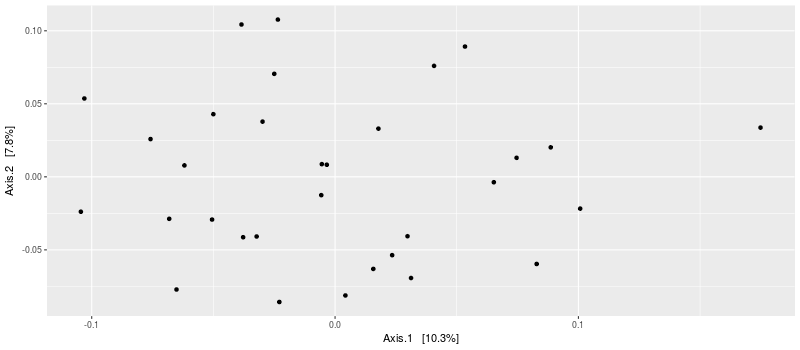

In [86]:
%%R -w 800 -h 350
pcoa = ordinate(phy.st, 
                method = "PCoA", 
                distance = bray.dist)
plot_ordination(phy.st, pcoa) %>% print
p.df = plot_ordination(phy.st, pcoa, justDF = TRUE)

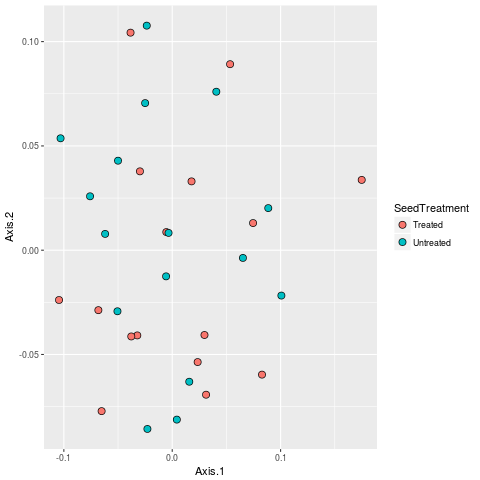

In [87]:
%%R
## generating plots
p1 = ggplot(p.df, aes(x = Axis.1, y = Axis.2)) +
        geom_point(aes(fill=SeedTreatment), pch = 21, size = 3)
        #scale_size(range=c(2,8))

#p2 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        #geom_point(aes(fill=Plant, size = BD), pch=21) +
        #scale_size(range=c(2,8))

grid.arrange(p1, ncol=1)

# Adonis testing treatment effects

In [88]:
%%R
set.seed(101)

df = as(sample_data(phy.st), "data.frame")
d = bray.dist
#df$Fert = as.factor(df$Fert)
Fulladonis = adonis(formula = d ~ Rep + Genotype*SeedTreatment, df, 
                    permutations = 999)
Fulladonis


Call:
adonis(formula = d ~ Rep + Genotype * SeedTreatment, data = df,      permutations = 999) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                       Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)    
Rep                     3   0.19504 0.065014 1.80409 0.16148  0.001 ***
Genotype                3   0.11583 0.038611 1.07141 0.09590  0.208    
SeedTreatment           1   0.03695 0.036949 1.02530 0.03059  0.351    
Genotype:SeedTreatment  3   0.10325 0.034416 0.95501 0.08548  0.673    
Residuals              21   0.75678 0.036037         0.62655           
Total                  31   1.20785                  1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [89]:
%%R
ordMean = p.df %>% 
    group_by(Genotype, R_Year, SeedTreatment) %>%
    summarize(mAxis.1 = mean(Axis.1),
                seAxis.1 = sd(Axis.1)/sqrt(length(Axis.1)),
             mAxis.2 = mean(Axis.2), 
             seAxis.2 = sd(Axis.2)/sqrt(length(Axis.2)))

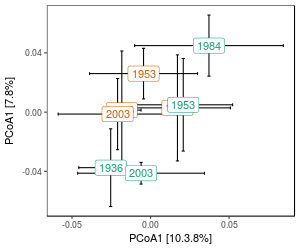

In [90]:
%%R -w 300 -h 250
p1 = ggplot(ordMean, aes(x = mAxis.1, y = mAxis.2, label = R_Year, color = SeedTreatment)) +
    geom_point()+
    theme_pub()+
    scale_color_manual(values = TreatmentColors)+
    geom_errorbar(aes(ymin = mAxis.2 - seAxis.2, ymax = mAxis.2 + seAxis.2),      
                color = "black",
                width = .002) +
    geom_errorbarh(aes(xmin = mAxis.1 - seAxis.1, xmax = mAxis.1 + seAxis.1),color = "black",
                height = .002)+
    geom_label(aes(color = SeedTreatment)) +
    theme(legend.position = "none")+
    xlab("PCoA1 [10.3.8%]")+
    ylab("PCoA1 [7.8%]")
p1

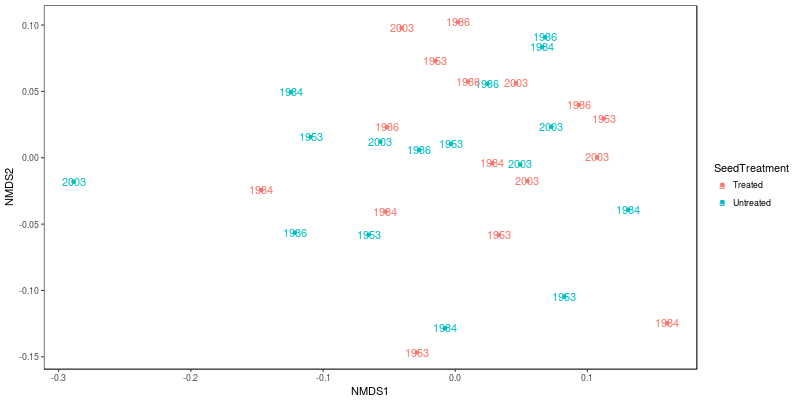

In [31]:
%%R -w 800 -h 400
p2 = ggplot(p, aes(x = NMDS1, y = NMDS2, label = R_Year, color = SeedTreatment)) +
    geom_point()+
    theme_pub()+
    geom_text(aes(color = SeedTreatment)) +
    #theme(legend.position = "none")+
    xlab("NMDS1")+
    ylab("NMDS2")
p2

# Alpha diversity

In [24]:
%%R
F = file.path('/home/bryan/ERA/data/MiSeq/20170417_run1/phyloseq/ERA_thresh.rds')
physeq.Full = readRDS(F)

#rarefy to standard depth
set.seed(45)
phy.st.r = rarefy_even_depth(physeq.Full) %>%
    subset_samples(Genotype %in% c("322", "3475", "34N42", "354") & TimePoint == "T2")
   


phy.st.r

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4592 taxa and 32 samples ]
sample_data() Sample Data:       [ 32 samples by 46 sample variables ]
tax_table()   Taxonomy Table:    [ 4592 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4592 tips and 4591 internal nodes ]


In [26]:
%%R
alpha_meas = c("Observed", "Chao1", "Shannon", "Simpson")
p = plot_richness(phy.st.r, measures=alpha_meas)

p$data$Fert = as.factor(p$data$Fert)
p$data$R_Year.c = p$data$R_Year - 1935

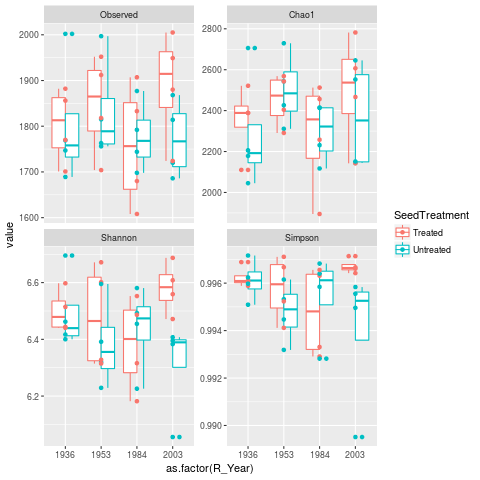

In [27]:
%%R

ggplot(p$data, aes(x = as.factor(R_Year), y = value, color = SeedTreatment)) +
geom_boxplot() +
geom_point()+
facet_wrap(~variable, ncol = 2, scales = "free_y")

In [44]:
%%R
#test library effects on microbial diversity
tmp = p$data %>% filter(variable == "Chao1")

fit1 = lmer(value~ Genotype*SeedTreatment + (1|Rep), data = tmp)
anova(fit1, ddf="Kenward-Roger") %>% print


Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
                       Sum Sq Mean Sq NumDF DenDF F.value Pr(>F)
Genotype               200138   66713     3    21 2.36366 0.1001
SeedTreatment            8436    8436     1    21 0.29888 0.5903
Genotype:SeedTreatment  38258   12753     3    21 0.45183 0.7187


In [45]:
%%R
dfC = lsmeans(fit1, pairwise~SeedTreatment|Genotype, ddf="Kenward-Roger") %>%
    summary %>%
        .$lsmeans %>%
        as.data.frame()
     
dfC

  SeedTreatment Genotype   lsmean       SE       df lower.CL upper.CL
1       Treated      322 2352.354 112.4149 10.14809 2102.373 2602.335
2     Untreated      322 2283.947 112.4149 10.14809 2033.966 2533.929
3       Treated     3475 2280.376 112.4149 10.14809 2030.395 2530.357
4     Untreated     3475 2294.203 112.4149 10.14809 2044.222 2544.185
5       Treated    34N42 2499.486 112.4149 10.14809 2249.504 2749.467
6     Untreated    34N42 2373.399 112.4149 10.14809 2123.418 2623.380
7       Treated      354 2451.624 112.4149 10.14809 2201.642 2701.605
8     Untreated      354 2502.399 112.4149 10.14809 2252.418 2752.381


In [46]:
%%R
#test library effects on microbial diversity
tmp = p$data %>% filter(variable == "Shannon")

fit1 = lmer(value~ Genotype*SeedTreatment + (1|Rep), data = tmp)
anova(fit1, ddf="Kenward-Roger") %>% print


Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
                         Sum Sq  Mean Sq NumDF DenDF F.value Pr(>F)
Genotype               0.031649 0.010550     3    21 0.59993 0.6222
SeedTreatment          0.050375 0.050375     1    21 2.86463 0.1053
Genotype:SeedTreatment 0.120751 0.040250     3    21 2.28889 0.1079


In [47]:
%%R
dfS = lsmeans(fit1, pairwise~SeedTreatment|Genotype, ddf="Kenward-Roger") %>%
    summary %>%
        .$lsmeans %>%
        as.data.frame()
     
dfS

  SeedTreatment Genotype   lsmean         SE       df lower.CL upper.CL
1       Treated      322 6.499230 0.07301219 19.75111 6.346806 6.651654
2     Untreated      322 6.493715 0.07301219 19.75111 6.341291 6.646138
3       Treated     3475 6.384224 0.07301219 19.75111 6.231800 6.536648
4     Untreated     3475 6.438621 0.07301219 19.75111 6.286197 6.591045
5       Treated    34N42 6.581627 0.07301219 19.75111 6.429203 6.734051
6     Untreated    34N42 6.310480 0.07301219 19.75111 6.158056 6.462904
7       Treated      354 6.478959 0.07301219 19.75111 6.326535 6.631383
8     Untreated      354 6.383813 0.07301219 19.75111 6.231389 6.536237


In [53]:
%%R
dfS$Variable = "Shannon"
dfC$Variable = "Chao 1"
df = bind_rows(dfS, dfC)
dfS = NULL
dfC = NULL

In [54]:
%%R
df %>% head

  SeedTreatment Genotype   lsmean         SE       df lower.CL upper.CL
1       Treated      322 6.499230 0.07301219 19.75111 6.346806 6.651654
2     Untreated      322 6.493715 0.07301219 19.75111 6.341291 6.646138
3       Treated     3475 6.384224 0.07301219 19.75111 6.231800 6.536648
4     Untreated     3475 6.438621 0.07301219 19.75111 6.286197 6.591045
5       Treated    34N42 6.581627 0.07301219 19.75111 6.429203 6.734051
6     Untreated    34N42 6.310480 0.07301219 19.75111 6.158056 6.462904
  Variable
1  Shannon
2  Shannon
3  Shannon
4  Shannon
5  Shannon
6  Shannon


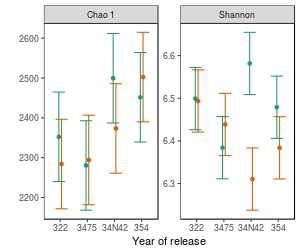

In [77]:
%%R -w 300 -h 250
## Graph seed treatments

df = df %>% mutate(Genotype = factor(Genotype, levels = c("322", "354", "3475", "34N42")))

p = ggplot(tmp, aes(x = Genotype, y = lsmean, color = SeedTreatment)) +
geom_point(position=position_dodge(width=.2))+
geom_errorbar(aes(ymin = lsmean - SE, ymax = lsmean + SE), position=position_dodge(width=.2))+
theme_pub() +
scale_color_manual(values = TreatmentColors)+
facet_wrap(~Variable, scales = "free_y")+
xlab("Year of release") +
ylab("")+
theme(legend.position = "none")
p
